## **Name of group members:**

- **NGUEPONWOUO Joseph-Marie**
- **GARDIN Emmanuel**



### **NUMERICAL METHODS FOR PDE IN FINANCE : MEAN FIELD GAMES WITH CONGESTION EFFECTS**

In [33]:
import numpy as np
import os
import pickle
import scipy
import scipy.sparse as sp
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# **1. Finite Differences Operators**

We introduce the following finite differences operators:

$$
∂_t \ w(t_n, x) \Longleftrightarrow  (D_t \ W)^n = \frac{W^{n+1} - W^n}{\Delta t}, \ \ n \in {0, ..., N_T - 1}, \ W \in \mathbb{R}^{N_T + 1} \\
∂_x \ w(t, x_i) \Longleftrightarrow  (D_x \ W)_i = \frac{W_{i+1} - W_i}{h}, \ \ i \in {0, ..., N_h - 1}, \ W \in \mathbb{R}^{N_h} \\
∂_x^2 \ w(t, x_i) \Longleftrightarrow  (\Delta_h \ W)_i = \frac{W_{i+1} - 2W_i + W_{i-1}}{h^2}, \ \ i \in {0, ..., N_h - 1}, \ W \in \mathbb{R}^{N_h} \\
[∇_h W]_i = ((DW)_i, (DW)_{i-1}), \ \ i \in {0, ..., N_h - 1}, \ W \in \mathbb{R}^{N_h}
$$


$$
\left(\partial_x (t_n, x_i) \right)_{}
\longleftrightarrow
\frac{1}{h}
\begin{pmatrix}
-1 & 1 & 0 & 0 & \cdots & 0 \\\\
0 & -1 & 1 & 0 & \cdots & 0 \\\\
0 & 0 & -1 & 1 & \cdots & 0 \\\\
\vdots & \vdots & \vdots & \ddots & \ddots & \vdots \\\\
0 & 0 & 0 & \cdots & -1 & 1 \\\\
0 & 0 & 0 & \cdots & 0 & 0
\end{pmatrix}
\quad
\begin{pmatrix}
W_0^0 & W_0^1 & \cdots & W_0^{N_T} \\\\
W_1^0 & W_1^1 & \cdots & W_1^{N_T} \\\\
\vdots & \vdots & \ddots & \vdots \\\\
W_{N_h-1}^0 & W_{N_h-1}^1 & \cdots & W_{N_h-1}^{N_T}
\end{pmatrix}
$$

In the last row, we took into account Neumann conditions, considering the fact that $U_{N_h} = U_{N_h - 1}$ and $M_{N_h} = M_{N_h - 1}$. Let $D_x$ be the matrix above.

Again, taking into account Neumann conditions:

$$
\left( \partial_x^2 (t_n, x_i) \right)_{\substack{0 \leq n \leq N_T \\ 0 \leq i \leq N_h - 1}}
\longleftrightarrow
\frac{1}{h^2}
\begin{pmatrix}
-1 & 1 & 0 & 0 & \cdots & 0 \\\\
1 & -2 & 1 & 0 & \cdots & 0 \\\\
0 & 1 & -2 & 1 & \cdots & 0 \\\\
\vdots & \vdots & \ddots & \ddots & \ddots & \vdots \\\\
0 & 0 & \cdots & 0 & -2 & 1 \\\\
0 & 0 & \cdots & 0 & 1 & -1
\end{pmatrix}
\quad
\begin{pmatrix}
W_0^0 & W_0^1 & \cdots & W_0^{N_T} \\\\
W_1^0 & W_1^1 & \cdots & W_1^{N_T} \\\\
\vdots & \vdots & \ddots & \vdots \\\\
W_{N_h-1}^0 & W_{N_h-1}^1 & \cdots & W_{N_h-1}^{N_T}
\end{pmatrix}
$$

Denote by $D_x^2$ the matrix above.

Notice that the matrix of

$$
((DW)_{i-1} = \frac{1}{h}(W_i - W_{i-1}))_{0 \leq i < N_h}
$$

is (because of Neumann conditions):

$$
\frac{1}{h}
\begin{pmatrix}
0 & 0 & 0 & 0 & \cdots & 0 \\\\
-1 & 1 & 0 & 0 & \cdots & 0 \\\\
0 & -1 & 1 & 0 & \cdots & 0 \\\\
\vdots & \vdots & \ddots & \ddots & \ddots & \vdots \\\\
0 & 0 & \cdots & 0 & -1 & 1
\end{pmatrix}
$$




# **2. Solving HJB Equation**

To elaborate a discrete version of the HJB equation, we need to have a discrete version of the Hamiltonian. We will model $H_0(p, \mu) = \frac{1}{\beta} \frac{|p|^\beta}{(c_0 + c_1 \mu)^\alpha}$ by:

$$
\tilde{H}(p_1, p_2, \mu) = \frac{1}{\beta} \frac{\left( (p_1)_-^2 + (p_2)_+^2 \right)^{\frac{\beta}{2}}}{(c_0 + c_1 \mu)^\alpha} \tag{16}
$$

where $x_+ = \max(0, x)$ and $x_- = \max(0, -x)$. Note that $\tilde{H}$ takes three arguments.

We can now consider the following discrete version of the HJB equation, supplemented with the Neumann conditions and the terminal condition:

$$
\left\{
\begin{aligned}
    &-(D_t U_i)^n - \nu (\Delta_h U^n)_i + \tilde{H}(\nabla_h U^n]_i, M_i^{n+1}) = g(x_i) + \tilde{f}_0(M_i^{n+1}), & \quad 0 \le i < N_h, \; 0 \le n < N_T \\\\
    &U_{-1}^n = U_0^n, & \quad 0 \le n < N_T \\\\
    &U_{N_h}^n = U_{N_h-1}^n, & \quad 0 \le n < N_T \\\\
    &U_i^{N_T} = \phi(M_i^{N_T}), & \quad 0 \le i < N_h
\end{aligned}
\right.
\tag{17}
$$

This scheme is an implicit Euler scheme since the equation is backward in time. Given $M^{n+1}$ and $U^{n+1}$, we will solve equation $(17)$ for $U^n$.

We introduce

$$
\mathbb{F}(U^n, U^{n+1}, M^{n+1}) :=
\begin{pmatrix}
-(D_t U_0)^n - \nu (\Delta_h U^n)_0 + \tilde{H}([\nabla_h U^n]_0, M_0^{n+1}) - g(x_0) - \tilde{f}_0(M_0^{n+1}) \\\\
\vdots \\\\
-(D_t U_i)^n - \nu (\Delta_h U^n)_i + \tilde{H}([\nabla_h U^n]_i, M_i^{n+1}) - g(x_i)  - \tilde{f}_0(M_i^{n+1}) \\\\
\vdots \\\\
-(D_t U_{N_h-1})^n - \nu (\Delta_h U^n)_{N_h-1} + \tilde{H}([\nabla_h U^n]_{N_h-1}, M_{N_h - 1}^{n+1}) - g(x_{N_h-1})- \tilde{f}_0(M_{N_h-1}^{n+1})
\end{pmatrix}
$$

When solving the HJB equation, our goal is to find $U^n$ knowing $U^{n+1}$ and $M^{n+1}$. The condition $U_i^{N_T} = \phi(M_i^{N_T})$ allows initialization for $n = N_T$. For $n < N_T$, we use Newton-Raphson iterations, which consists in estimating $U^n$ as the limit of a sequence $(U^{n, k})_k$ defined by

$$
U^{n, k+1} = U^{n, k} - \mathbb{J}^{-1}(U^{n, k}, U^{n+1}, M^{n+1}) \mathbb{F}(U^{n, k}, U^{n+1}, M^{n+1}) \tag{18}
$$

where $\mathbb{J}(V, U^{n+1}, M^{n+1})$ is the Jacobian of the map $V \mapsto \mathbb{F}(V, U^{n+1}, M^{n+1})$.

We may initialize $U^{n, 0} = U^{n+1}$. The Newton iterations are stopped when $\|\mathbb{F}(U^{n, k}, U^{n+1}, M^{n+1})\|$ is below a given threshold, say $10^{-12}$.

**Closed form of the Jacobian**  
Let $\mathbb{F}_i$ be the $i$-th coordinate of $\mathbb{F}(U^n, U^{n+1}, M^{n+1})$. The Jacobian of the function $V \mapsto \mathbb{F}(V, U^{n+1}, M^{n+1})$ is defined as:

$$
\mathbb{J}(V, U^{n+1}, M^{n+1}) =
\begin{pmatrix}
\frac{\partial \mathbb{F}_0}{\partial V_0} & \frac{\partial \mathbb{F}_0}{\partial V_1} & \cdots & \frac{\partial \mathbb{F}_0}{\partial V_{N_h-1}} \\\\
\frac{\partial \mathbb{F}_1}{\partial V_0} & \frac{\partial \mathbb{F}_1}{\partial V_1} & \cdots & \frac{\partial \mathbb{F}_1}{\partial V_{N_h-1}} \\\\
\vdots & \vdots & \ddots & \vdots \\\\
\frac{\partial \mathbb{F}_{N_h-1}}{\partial V_0} & \frac{\partial \mathbb{F}_{N_h-1}}{\partial V_1} & \cdots & \frac{\partial \mathbb{F}_{N_h-1}}{\partial V_{N_h-1}}
\end{pmatrix}
\tag{19}
$$

Notice that (setting $A = -g(x_i) - \tilde{f}_0(M_i^{n+1})$):

$$
\mathbb{F}_i = -(D_t U_i)^n - \nu (\Delta_h U^n)_i + \tilde{H}([\nabla_h U^n]_i, M_i^{n+1}) - g(x_i) - \tilde{f}_0(M_i^{n+1})
$$
$$
= -\frac{U_i^{n+1} - U_i^n}{\Delta t} - \nu \frac{U_{i+1}^n - 2U_i^n + U_{i-1}^n}{h^2} + \frac{1}{\beta (c_0 + c_1 M_i^{n+1})^\alpha h^\beta} \left( ((U_{i+1}^n - U_i^n)_-)^2 + ((U_i^n - U_{i-1}^n)_+)^2 \right)^{\beta/2} + A
$$

This term only depends on $U_{i-1}^n, U_i^n, U_{i+1}^n$, so the Jacobian is a tridiagonal matrix. Moreover:

$$
\frac{\partial \mathbb{F}_i}{\partial U_{i-1}^n} = -\frac{\nu}{h^2} - \frac{1}{(c_0 + c_1 M_i^{n+1})^\alpha h^\beta} (U_i^n - U_{i-1}^n)_+ \left( ((U_{i+1}^n - U_i^n)_-)^2 + ((U_i^n - U_{i-1}^n)_+)^2 \right)^{\beta/2 - 1}
$$

$$
\frac{\partial \mathbb{F}_i}{\partial U_i^n} = \frac{1}{\Delta t} + \frac{2\nu}{h^2} + \frac{1}{(c_0 + c_1 M_i^{n+1})^\alpha h^\beta} \left( (U_{i+1}^n - U_i^n)_- - (U_i^n - U_{i-1}^n)_+ \right) \left( ((U_{i+1}^n - U_i^n)_-)^2 + ((U_i^n - U_{i-1}^n)_+)^2 \right)^{\beta/2 - 1}
$$

$$
\frac{\partial \mathbb{F}_i}{\partial U_{i+1}^n} = -\frac{\nu}{h^2} - \frac{1}{(c_0 + c_1 M_i^{n+1})^\alpha h^\beta} (U_{i+1}^n - U_i^n)_- \left( ((U_{i+1}^n - U_i^n)_-)^2 + ((U_i^n - U_{i-1}^n)_+)^2 \right)^{\beta/2 - 1}
$$

Let us denote $J_H$ the Jacobian of $U^n \mapsto \left( \tilde{H}([\nabla_h U^n]_i, M_i^{n+1}) \right)_{0 \le i < N_h}$ evaluated in $U^n$, in the equations above. It will be useful in the sequel. From what we have above, its coefficients verify:

$$
(J_H)_{i, i-1} = -\frac{1}{(c_0 + c_1 M_i^{n+1})^\alpha h^\beta} (U_i^n - U_{i-1}^n)_+ \left( (U_{i+1}^n - U_i^n)_-^2 + (U_i^n - U_{i-1}^n)_+^2 \right)^{\beta/2 - 1} \tag{20}
$$

$$
(J_H)_{i, i} = \frac{1}{(c_0 + c_1 M_i^{n+1})^\alpha h^\beta} \left( (U_{i+1}^n - U_i^n)_- + (U_i^n - U_{i-1}^n)_+ \right)
\left( (U_{i+1}^n - U_i^n)_-^2 + (U_i^n - U_{i-1}^n)_+^2 \right)^{\beta/2 - 1} \tag{21}
$$

$$
(J_H)_{i, i+1} = -\frac{1}{(c_0 + c_1 M_i^{n+1})^\alpha h^\beta} (U_{i+1}^n - U_i^n)_-
\left( (U_{i+1}^n - U_i^n)_-^2 + (U_i^n - U_{i-1}^n)_+^2 \right)^{\beta/2 - 1} \tag{22}
$$


# **3. Solving KFP Equation**

To define an appropriate discretization of the KFP equation, we first discuss how to discretize

$$
\partial_x \left( m(t, \cdot) |\partial_x u(t, \cdot)|^{\beta - 2} \partial_x u(t, \cdot) \right)(x).
$$

Recall that

$$
\partial_x \left( m(t, x) |\partial_x u(t, \cdot)|^{\beta - 2} \partial_x u(t, \cdot) \right)(x)
= \partial_x \left( m(t, x) \partial_p H_0(\partial_x u(t, x), m(t, x) \right) \tag{23}
$$

Let us consider a function $w \in C^\infty([0, T] \times \Omega)$. Using integration by parts and recalling Neumann boundary conditions, assuming $\partial_p H(x, 0, m) = 0$, we get:

$$
- \int_{\Omega} \partial_x \big( H_p(\partial_x u(t,x), m(t,x)) m(t,x) \big) w(t,x) \,dx
= \int_{\Omega} m(t,x) H_p(\partial_x u(t,x), m(t,x)) \partial_x w(t,x) \,dx,
$$


It is natural to propose the following approximation of the right-hand side above:

$$
h \sum_{i=0}^{N_h - 1} M_i^{n+1} \left(
\partial_{p_1} \tilde{H}(\nabla_h U^n]_i, M_i^{n+1}) \frac{W_{i+1}^n - W_i^n}{h}
+ \partial_{p_2} \tilde{H}([\nabla_h U^n]_i, M_i^{n+1}) \frac{W_i^n - W_{i-1}^n}{h}
\right) \tag{24}
$$

Performing discrete integration by parts, we obtain the discrete counterpart of the left-hand side as

$$
- h \sum_{i=0}^{N_h - 1} \mathbb{T}_i(U^n, M^{n+1}, M^{n+1}) W_i^n,
$$

where

$$
\mathbb{T}_i(U, M, \tilde{M}) = \frac{1}{h} \left(
M_i \partial_{p_1} \tilde{H}([\nabla_h U^n]_i, \tilde{M}_i)
- M_{i-1} \partial_{p_1} \tilde{H}([\nabla_h U^n]_{i-1}, \tilde{M}_i)
\right) \tag{25}
$$
$$
+ \frac{1}{h} \left(
M_{i+1} \partial_{p_2} \tilde{H}(\nabla_h U^n]_{i+1}, \tilde{M}_{i+1})
- M_i \partial_{p_2} \tilde{H}([\nabla_h U^n]_i, \tilde{M}_i)
\right) \tag{26}
$$

We can now consider the following discrete version of the KFP equation, supplemented with the Neumann conditions and the terminal condition:

$$
\left\{
\begin{aligned}
& (D_t M_i)^n - \nu (\Delta_h M^{n+1})_i - \mathbb{T}_i(U^n, M^{n+1}, \tilde{M}^{n+1}) = 0, && 0 \le i < N_h, \; 0 < n < N_T \\\\
& M_{-1}^n = M_0^n, && 0 < n \le N_T \\\\
& M_{N_h}^n = M_{N_h-1}^n, && 0 < n \le N_T \\\\
& M_i^0 = \tilde{m}_0(x_i), && 0 \le i < N_h
\end{aligned}
\right. \tag{27}
$$

where for example:

$$
\tilde{m}_0(x_i) =  \frac{1}{h}\int_{|x - x_i| \le h/2} m_0(x) \, dx \quad \text{or} \quad \tilde{m}_0(x_i) = m_0(x_i) \tag{28}
$$

This scheme is also implicit, but contrary to the HJB scheme, it consists in a forward loop. Starting from time step $0$, $M_i^0 = \tilde{m}_0(x_i)$ provides an explicit formula for $M^0$. The $n$-th step consists in computing $M^{n+1}$ given $U^n$ and $M^n$. The KFP system $(26)$ being linear, it can be solved by basic linear algebra methods.

**Proposition 3.**  
We introduce

$$
\mathbb{T}(U, M, \tilde{M}) := (\mathbb{T}_0(U, M,  \tilde{M}), \ldots, \mathbb{T}_{N_h - 1}(U, M,  \tilde{M}))^T.
$$

Notice that $M \mapsto \mathbb{T}(U^n, M, \tilde{M})$ is a linear map. Let $A$ be the associated matrix. Then

$$
A = (-J_H)^T.
$$


Considering the fact that

$$
(D_t M)^n = \frac{1}{\Delta t} (M^{n+1} - M^n),
$$

we can finally rewrite our system:

$$
\frac{M^{n+1} - M^n}{\Delta t} - \nu D_x^2 M^{n+1} + (J_H)^T M^{n+1} = 0 \tag{28}
$$

Finding $M^{n+1}$ then amounts to solving:

$$
\left( I_{N_h} - \nu \Delta t D_x^2 + \Delta t (J_H)^T \right) M^{n+1} = M^n \tag{29}
$$



# **4. Solving the whole forward-backward system**

The idea will be to use fixed points iterations to compute
$$
\mathbb{M} := (M^n)_{0 \le n \le N_T} \quad \text{and} \quad \mathbb{U} := (U^n)_{0 \le n \le N_T}.
$$
Let $0 < \theta < 1$ be a parameter (for instance, $\theta = 0.01$). Let
$$
(\mathbb{M}^{(k)}, \mathbb{U}^{(k)})
$$
be the running approximation of $(\mathbb{M}, \mathbb{U})$. The next approximation
$$
(\mathbb{M}^{(k+1)}, \mathbb{U}^{(k+1)})
$$
is computed as follows:

- Solve the discrete HJB equation given $(\mathbb{M}^{(k)}, \mathbb{U}^{(k)})$. The solution is named $\hat{U}^{(k+1)}$.
- Solve the discrete KFP equation given $(\mathbb{M}^{(k)}, \hat{U}^{(k+1)})$. The solution is named $\hat{\mathbb{M}}^{(k+1)}$.
- Set
$$
(\mathbb{M}^{(k+1)}, \mathbb{U}^{(k+1)}) = (1 - \theta)(\mathbb{M}^{(k)}, \mathbb{U}^{(k)}) + \theta (\hat{\mathbb{M}}^{(k+1)}, \hat{U}^{(k+1)}).
$$

The iterations are stopped when the norm of the increment
$$
(\mathbb{M}^{(k+1)}, \mathbb{U}^{(k+1)}) - (\mathbb{M}^{(k)}, \mathbb{U}^{(k)})
$$
becomes smaller than a given threshold, say $10^{-7}$.

To initialize the loop, we set
$$
M_i^{n, (0)} = \tilde{m}_0(x_i)
$$
for all $0 \le i < N_h$ and $0 \le n \le N_T$. The matrix $U^{(0)}$ initial value has minimum consequence on the convergence of the algorithm. We set
$$
U_i^{n, (0)} = 0
$$
for all $i, n$.


# **Code Section**

In [34]:
# Grid parameters
T = 1.0
N_h = 201
N_T = 100
dt = T/N_T
h = 1/(N_h - 1)
time_grid = np.arange(0, T+dt, dt)
space_grid = np.arange(0, 1+h, h)
newton_stopping_criteria = 1e-12
fixed_point_stopping_criteria = 2e-5
sqrt_N_h = np.sqrt(N_h)

# Model parameters
beta_list = [2.0, 2.0, 2.0, 2.0, 2.0]
c0_list = [0.1, 0.1, 0.01, 0.01, 1]
c1_list = [1, 5, 2, 2, 3]
alpha_list = [0.5, 1, 1.2, 1.5, 2]
sigma_list = [0.02, 0.02, 0.1, 0.2, 0.002]
theta_list = [0.05, 0.05, 0.05, 0.05, 0.005]
newton_criteria_list = [1e-12, 1e-12, 1e-10, 1e-10, 1e-12]

In [35]:
# Model functions

def g(x):
    return 0

def H0(p1, p2, M):
    return (1/beta) * (((np.minimum(0, p1))**2 + (np.maximum(0, p2))**2)**(beta/2)) / (c0 + c1 * M)**alpha

def f0_tilde(m):
    return m/10

def phi(x):
    return - np.exp(-40 * (x - 0.7)**2)

def m0(x):
    return np.sqrt(300/np.pi) * np.exp(-300 * (x - 0.2) ** 2)

def m0_hat(x):
    return m0(x)

In [36]:
def diff_operators(N_h, h):
    # (DW_i)_{0 \leq i < N_h}
    main_diag_Dx = np.full(N_h, -1)
    main_diag_Dx[-1] = 0
    super_diag_Dx = np.full(N_h - 1, 1)
    Dx = sp.diags([main_diag_Dx, super_diag_Dx], [0, 1], shape=(N_h, N_h)) / h

    # # (DW_{i-1})_{0 \leq i < N_h}
    main_diag_Dx_shift = np.full(N_h, 1)
    main_diag_Dx_shift[0] = 0
    sub_diag_Dx_shift = np.full(N_h - 1, -1)
    Dx_shift = sp.diags([sub_diag_Dx_shift, main_diag_Dx_shift], [-1, 0], shape=(N_h, N_h)) / h

    # Discrete Laplacian
    main_diag_Dx2 = np.full(N_h, -2)
    main_diag_Dx2[0] = -1
    main_diag_Dx2[-1] = -1
    sub_diag_Dx2 = np.full(N_h - 1, 1)
    super_diag_Dx2 = np.full(N_h - 1, 1)
    Dx2 = sp.diags([sub_diag_Dx2, main_diag_Dx2, super_diag_Dx2], [-1, 0, 1], shape=(N_h, N_h)) / h**2

    return Dx, Dx_shift, Dx2

Dx, Dx_shift, Dx2 = diff_operators(N_h, h)

In [37]:
def compute_F(U_next, U_now, M, denominator_F):
    """
    Compute the residual F for the discretized HJB equation
    Args:
        U_next: Solution at next time step
        U_now: Current solution iterate
        M: Mass/density at current time step
        denominator: Precomputed term for efficiency
    """
    # Time derivative and diffusion terms
    F = - (U_next - U_now) / dt - nu * Dx2 @ U_now
    
    # Spatial derivatives for Hamiltonian
    DxU = Dx @ U_now
    Dx_shift_U = Dx_shift @ U_now
    
    # Nonlinear Hamiltonian term using upwind scheme
    hamiltonian_term = denominator_F * (((np.minimum(0, DxU))**2 + (np.maximum(0, Dx_shift_U))**2)**(beta/2))
    
    # Complete residual with source terms
    F += hamiltonian_term - g(space_grid) - f0_tilde(M)
    return F


def compute_JH(U, M):
    """
    Compute the Jacobian matrix of the Hamiltonian term
    Returns a banded matrix representation
    """
    # Compute upwind derivatives
    backward_spatial_diff = np.maximum(Dx_shift @ U, 0)
    forward_spatial_diff = -np.minimum(Dx @ U, 0)
    
    # Coefficient for nonlinear term
    coef = backward_spatial_diff**2 + forward_spatial_diff**2
    coef = (1 / (c0 + c1 * M) ** alpha) * np.power(coef, beta/2-1, out=np.zeros_like(coef), where=(coef!=0))

    # Construct diagonal elements
    main_diag = (1/h) * (forward_spatial_diff + backward_spatial_diff) * coef
    sub_diag = (-1/h) * backward_spatial_diff * coef
    sup_diag = (-1/h) * forward_spatial_diff * coef

    # Assemble banded matrix
    banded_matrix = np.zeros((3, U.size))
    banded_matrix[0, 1:] = sup_diag[:-1]
    banded_matrix[1] = main_diag
    banded_matrix[2, :-1] = sub_diag[1:]
    return banded_matrix


def compute_J_banded(U, M, denominator_J):
    """
    Compute the full Jacobian matrix for the HJB equation
    Including time derivative, diffusion, and Hamiltonian terms
    """
    # Compute upwind derivatives
    backward_spatial_diff = np.maximum(Dx_shift @ U, 0)
    forward_spatial_diff = -np.minimum(Dx @ U, 0)
    
    # Coefficient for nonlinear term
    coef = backward_spatial_diff**2 + forward_spatial_diff**2
    coef = denominator_J * np.power(coef, beta/2-1, out=np.zeros_like(coef), where=(coef!=0))

    # Construct diagonal elements
    sub_diag = (-1/h) * backward_spatial_diff * coef
    main_diag = (1/h) * (forward_spatial_diff + backward_spatial_diff) * coef
    sup_diag = (-1/h) * forward_spatial_diff * coef

    # Assemble banded matrix with all terms
    banded_matrix = np.zeros((3, U.size))
    banded_matrix[0, 1:] = sup_diag[:-1] - nu_over_h2
    banded_matrix[1] = main_diag + 1/dt + 2*nu_over_h2
    banded_matrix[2, :-1] = sub_diag[1:] - nu_over_h2
    
    return banded_matrix

In [38]:
def Newton_Raphson(U, M):
    """
    Newton-Raphson method to solve the nonlinear system at each time step
    Args:
        U: Solution at previous time step
        M: Mass/density at current time step
    """
    # Initialize with previous solution
    U_k = U.copy()

    k = 0
    normF = np.inf
    
    denominator_F = 1 / (beta * (c0 + c1 * M) ** alpha)
    denominator_J = 1 / (c0 + c1 * M) ** alpha

    # Iterate until convergence
    while normF > newton_stopping_criteria:
        # Raise exception if too many iterations
        if k > 1000:
            print(f"Newton-Raphson iteration {k}, normF: {normF:.2e}")
            raise Exception("Newton-Raphson failed to converge after 1000 iterations")
            
        # Compute residual F and Jacobian J
        F = compute_F(U, U_k, M, denominator_F)
        J = compute_J_banded(U_k, M, denominator_J)

        # Update solution: U_{k+1} = U_k - J^{-1}F
        U_k = U_k - scipy.linalg.solve_banded((1, 1), J, F)
        
        # Check convergence using normalized residual
        normF = np.linalg.norm(F) / sqrt_N_h
        k += 1

    # Print warning if many iterations were needed
    if k > 100:
        print(f"Warning: Newton-Raphson needed {k} iterations to converge")

    return U_k

def solve_HJB(M):
    """
    Solve the Hamilton-Jacobi-Bellman equation backwards in time
    Args:
        M: Mass/density field for all time steps
    """
    # Initialize solution array
    U_hat = np.zeros(M.shape)
    # Set terminal condition
    U_hat[N_T] = phi(space_grid)

    # Backward time stepping
    for n in range(N_T-1, -1, -1):
        # Solve nonlinear system at each time step
        U_hat[n] = Newton_Raphson(U_hat[n+1], M[n+1])

    return U_hat

In [39]:
def solve_KFP(U, M):
    """
    Solve the Kolmogorov Forward Planning equation forward in time
    Args:
        U: Value function for all time steps
        M: Initial guess for mass/density field
    Returns:
        M_hat: Updated mass/density field solution
    """
    # Initialize solution array and set initial condition
    M_hat = np.zeros(U.shape)
    M_hat[0] = m0_hat(space_grid)

    # Precompute coefficients for second derivative operator
    Dx2_super = (1 / h**2) * np.ones(N_h - 1)
    Dx2_main = -2 * (1 / h**2) * np.ones(N_h)
    Dx2_main[0] = -1 / h**2
    Dx2_main[-1] = -1 / h**2
    Dx2_sub = (1 / h**2) * np.ones(N_h - 1)

    # Forward time stepping
    for n in range(N_T):
        # Compute Hamiltonian Jacobian for current time step
        JH_banded = compute_JH(U[n], M[n+1])
        
        # Construct system matrix coefficients (diffusion + transport terms)
        A_super = (-nu * dt) * Dx2_super + dt * JH_banded[2, :-1]  
        A_main = 1 + (-nu * dt) * Dx2_main + dt * JH_banded[1, :]  
        A_sub = (-nu * dt) * Dx2_sub + dt * JH_banded[0, 1:]  
        
        # Assemble banded matrix for linear system
        ab = np.zeros((3, N_h))
        ab[0, 1:] = A_super   # Upper diagonal
        ab[1, :] = A_main     # Main diagonal
        ab[2, :-1] = A_sub    # Lower diagonal
        
        # Solve linear system for next time step
        M_hat[n+1] = scipy.linalg.solve_banded((1, 1), ab, M_hat[n])

    return M_hat

In [40]:
def FixedPoint(U_old, M_old):
    """
    Fixed-point iteration to solve the coupled HJB-KFP system
    Args:
        U: Initial guess for value function
        M: Initial guess for mass/density field
    Returns:
        U_new, M_new: Converged solutions
    """
    # Parameter display string
    param_str = f"(β={beta}, c₀={c0}, c₁={c1}, α={alpha}, σ={sigma}, θ={theta}, Newton criteria={newton_stopping_criteria})"
    print(f"\nStarting Fixed Point iterations for parameter set {param_str}")
    
    # Initialize timing and iteration counter
    t0 = time.time()
    k = 0
    norm_increment = np.inf

    # Main iteration loop
    while norm_increment > fixed_point_stopping_criteria:
        # Step 1: Solve HJB equation backward in time
        U_hat = solve_HJB(M_old)
        # Step 2: Solve KFP equation forward in time
        M_hat = solve_KFP(U_hat, M_old)
        
        # Update solutions with relaxation parameter theta
        U_new = (1 - theta) * U_old + theta * U_hat
        M_new = (1 - theta) * M_old + theta * M_hat
        
        # Check convergence using normalized increment
        increment = np.hstack((U_new - U_old, M_new - M_old))
        norm_increment = np.linalg.norm(increment) / np.sqrt(N_h * (N_T + 1))
        k += 1
        
        # Update for next iteration
        U_old, M_old = U_new, M_new
        
        # Display progress and plot contours every 50 iterations
        if k % 50 == 0:
            print(f"Parameter set {param_str}: Iteration {k}, norm: {norm_increment:.2e}, elapsed time: {time.time() - t0:.1f}s")
            


    print(f"DONE {param_str}: {k} iterations, final norm: {norm_increment:.2e}, elapsed time: {time.time() - t0:.1f}s")
    return U_new, M_new

In [32]:
# Arrays to store solutions for different parameter sets
U_solutions = []
M_solutions = []

# Define a base filename for the pickled data
filename_base = "mfg_solutions_params"

# Ask the user if they want to load the data
load_data = input("Do you want to load existing pickled data if available? (y/n): ")
load_existing_data = load_data.lower() == 'y'

# Iterate over the parameter sets
for i in range(len(beta_list)):
    # Construct filename for this parameter set
    filename = f"{filename_base}_{i}.pkl"
    
    # Update global variables with current parameter set
    global beta, c0, c1, alpha, sigma, nu, nu_over_h2, theta, newton_stopping_criteria
    beta = beta_list[i]
    c0 = c0_list[i]
    c1 = c1_list[i]
    alpha = alpha_list[i]
    sigma = sigma_list[i]
    nu = sigma**2 / 2
    nu_over_h2 = nu/h**2
    theta = theta_list[i]
    newton_stopping_criteria = newton_criteria_list[i]

    # Recompute difference operators for new parameters
    Dx, Dx_shift, Dx2 = diff_operators(N_h, h)
    
    if os.path.exists(filename) and load_existing_data:
        # Load the data from the pickle file
        with open(filename, 'rb') as f:
            U_current, M_current = pickle.load(f)
        print(f"Loaded data from pickle file: {filename}")
        U_solutions.append(U_current)
        M_solutions.append(M_current)
    else:
        print(f"Computing solutions for parameter set {i}...")

        # Initialize mass/density field M(t,x) fresh for this iteration
        M = np.zeros((N_T+1, N_h))
        M[:] = m0_hat(space_grid)  # Reset to initial condition

        # Initialize value function U(t,x) fresh for this iteration
        U = np.zeros((N_T+1, N_h))
        U[:] = phi(space_grid)  # Reset to terminal condition

        # Solve the coupled HJB-KFP system using fixed-point iteration
        U_current, M_current = FixedPoint(U, M)

        # Store solutions
        U_solutions.append(U_current)
        M_solutions.append(M_current)

        # Save the data to a pickle file
        with open(filename, 'wb') as f:
            pickle.dump((U_current, M_current), f)
        print(f"Saved solutions to pickle file: {filename}")


Computing solutions for parameter set 0...

Starting Fixed Point iterations for parameter set (β=2.0, c₀=0.1, c₁=1, α=0.5, σ=0.02, θ=0.05, Newton criteria=1e-12)


KeyboardInterrupt: 

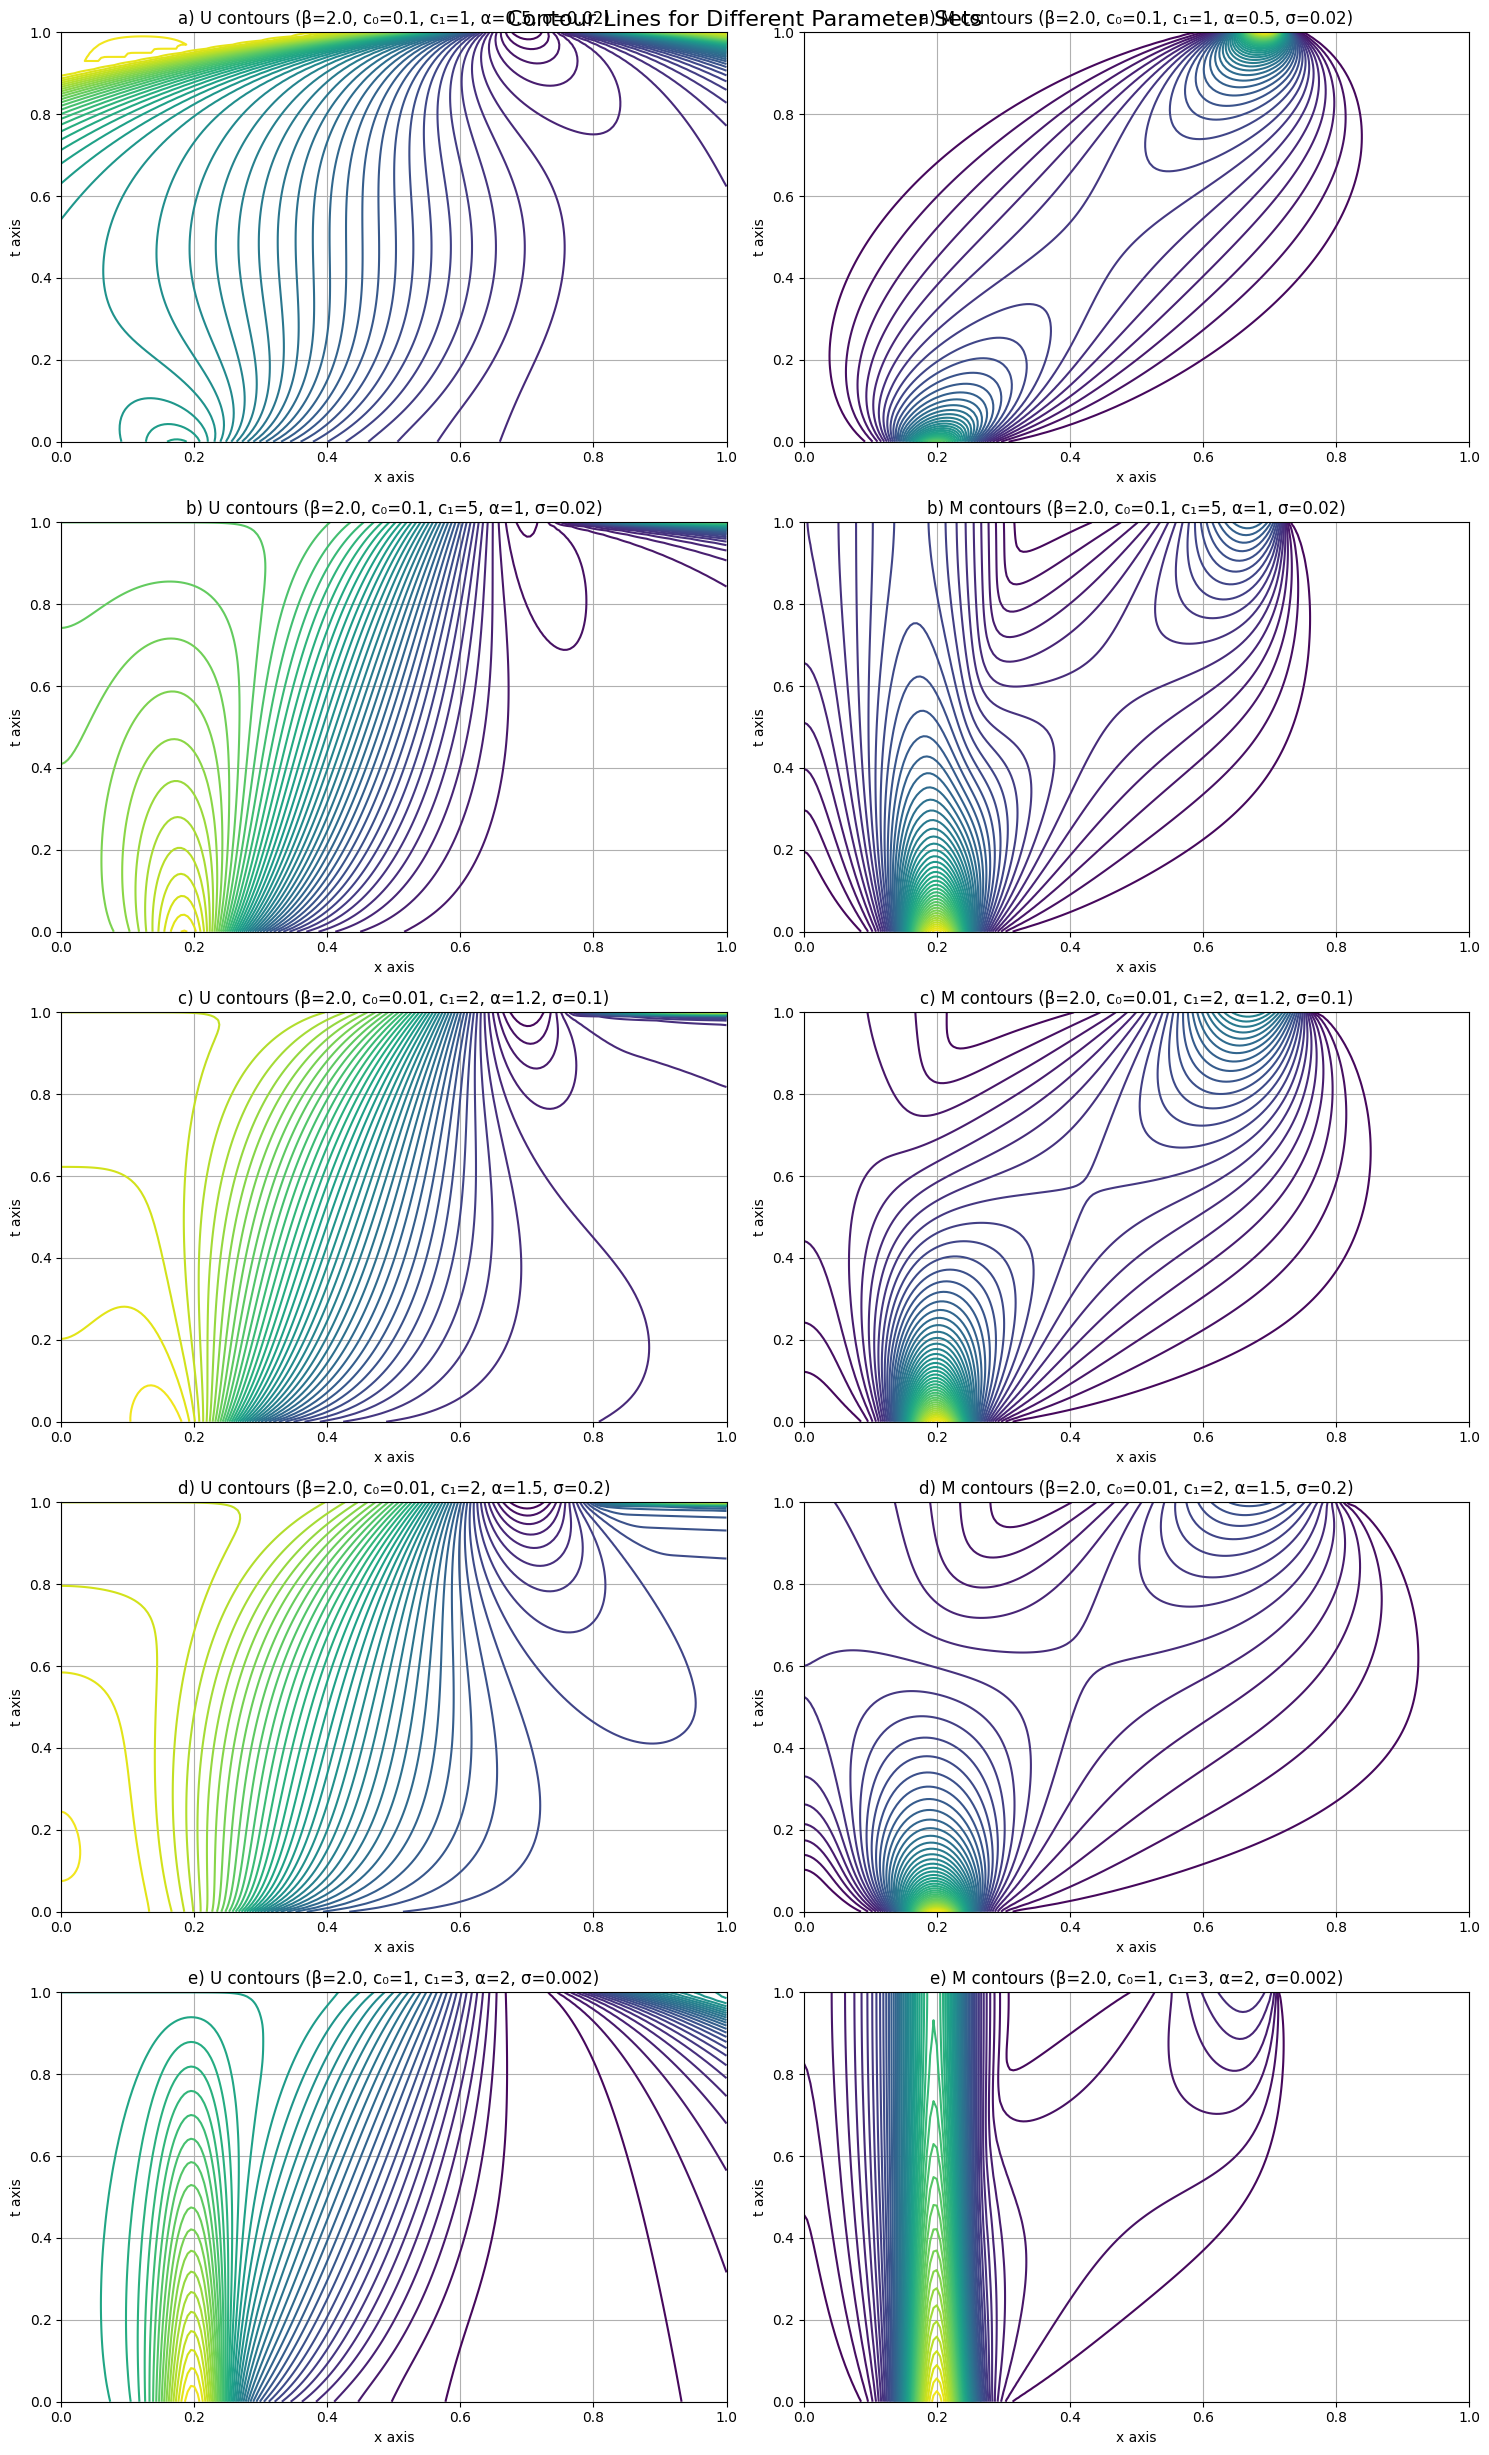

In [ ]:
fig, axes = plt.subplots(len(beta_list), 2, figsize=(15, 25))
fig.suptitle('Contour Lines for Different Parameter Sets', fontsize=16)

for i in range(len(beta_list)):
    # Plot U contours
    ct1 = axes[i,0].contour(space_grid, time_grid, U_solutions[i], levels=50)
    axes[i,0].set_title(f'{chr(97+i)}) U contours (β={beta_list[i]}, c₀={c0_list[i]}, c₁={c1_list[i]}, α={alpha_list[i]}, σ={sigma_list[i]})')
    axes[i,0].set_xlabel('x axis')
    axes[i,0].set_ylabel('t axis')
    axes[i,0].grid(True)
    
    # Plot M contours
    ct2 = axes[i,1].contour(space_grid, time_grid, M_solutions[i], levels=50)
    axes[i,1].set_title(f'{chr(97+i)}) M contours (β={beta_list[i]}, c₀={c0_list[i]}, c₁={c1_list[i]}, α={alpha_list[i]}, σ={sigma_list[i]})')
    axes[i,1].set_xlabel('x axis')
    axes[i,1].set_ylabel('t axis')
    axes[i,1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def create_animation(U, M, param_set):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    line1, = ax.plot(space_grid, M[0, :], color='blue', label='M')
    line2, = ax.plot(space_grid, U[0, :], color='red', label='U')
    
    param_text = f'β={beta_list[param_set]}, c₀={c0_list[param_set]}, c₁={c1_list[param_set]}, α={alpha_list[param_set]}, σ={sigma_list[param_set]}'
    ax.set_title(f'Evolution of U and M - Parameter Set {chr(97 + param_set)}\n{param_text}')
    ax.set_xlabel('Space')
    ax.set_ylabel('Values')
    ax.legend(loc='best')
    
    def init():
        line1.set_ydata([np.nan] * len(space_grid))
        line2.set_ydata([np.nan] * len(space_grid))
        return line1, line2
    
    def animate(i):
        line1.set_ydata(M[i, :])
        line2.set_ydata(U[i, :])
        return line1, line2
    
    ani = animation.FuncAnimation(
        fig, animate, init_func=init, interval=100, blit=True, frames=len(time_grid)
    )
    
    plt.close()
    return ani

# Save animations to files and show the animation for the second parameter set
for i in range(5):
    ani = create_animation(U_solutions[i], M_solutions[i], i)
    writer = animation.FFMpegWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(f'video_mfg_{chr(97 + i)}.mp4', writer='ffmpeg')
    if i == 1:
        display(HTML(ani.to_jshtml()))


**Remark:** We can notice from the different graphs obtained that we have two main focus points :

*   One at $x = 0.2$
*   The other one at $x = 0.7$

We can guess that this comes from the functions $\phi (x, m) = - \ exp(-40(x - 0.7)^2)$ and $m_0(x) = \sqrt{\frac{300}{\pi}} exp(-300(x - 0.2)^2)$


## **Theoretical Questions**

1. **Understand why the mass of $M^n$, i.e. $\sum_{i = 0}^{Nh - 1} M_i^n$, does not depend on n**

We consider that $M^n$ is a vector column. We recall that:

$$
M^n = (I_{Nh} - \nu \Delta t D_x^2 + \Delta t (J_H)^T) M^{n+1} := B \ M^{n+1}
$$

Let $v = (1 \ 1 \ ... \ 1) \in \mathbb{R}^{Nh}$. If we can prove that $B^T \ v = v$, then we are done as this would imply that $v^T \ B = v^T$ and then $v^T \ B \ M^{n+1} = v^T \ M^n \ \implies v^T \ M^{n+1} = v^T \ M^n$, which is basically what we are trying to show.

We have

$$
B^T \ v = (I_{Nh} - \nu \Delta t D_x^2 + \Delta t (J_H)^T) \ v
$$

The definition of the Jacobian matrix $J_H$ implies that the sum of the coefficients of $J_H$ over each row is zero and the same goes for matrix $D_x^2$ so that $(B^T \ v)_i = v_i$

Hence $B^T \ v = v $ and we can conclude.

2. **Try to prove uniqueness in the discrete HJB equation, i.e. that given $(M^n)_n$, $(U^n)_n$ is unique. Hint: take two solutions $(U^n)_n$ and $(V^n)_n$ and consider $n_0, i_0$ such that $max_{(n,i)} \ (U^n_i - V^n_i )$ is achieved at ($n_0,i_0$), and use the monotonicity of the discrete Hamiltonian**

Let $(U^n)_n$ and $(V^n)_n$ be two solutions of the HJB equation (given $(M^n)_n$). We consider $(n_0, i_0)$ such that $U_{i_0}^{n_0} - V_{i_0}^{n_0} = \max_{(n,i)}(U_i^n - V_i^n)$. Thus:


$$
\begin{equation*}
-(D_t U_{i_0})^{n_0} - \nu (\Delta_h U^{n_0})_{i_0} + \tilde{H}([\nabla_h U^{n_0}]_{i_0}, M_{i_0}^{n_0+1}) = -(D_t V_{i_0})^{n_0} - \nu (\Delta_h V^{n_0})_{i_0} + \tilde{H}([\nabla_h V^{n_0}]_{i_0}, M_{i_0}^{n_0+1})
\end{equation*}
$$

We can rearrange the terms:

$$
\begin{equation*}
\tilde{H}([\nabla_h U^{n_0}]_{i_0}, M_{i_0}^{n_0+1}) - \tilde{H}([\nabla_h V^{n_0}]_{i_0}, M_{i_0}^{n_0+1}) = (D_t U_{i_0})^{n_0} - (D_t V_{i_0})^{n_0} + \nu (\Delta_h U^{n_0})_{i_0} - \nu (\Delta_h V^{n_0})_{i_0}
\end{equation*}
$$

Knowing that $U_{i_0}^{n_0} - V_{i_0}^{n_0}$ is the largest difference possible, we have:

$$
\left\{
\begin{aligned}
& (D_t U_{i_0})^{n_0} - (D_t V_{i_0})^{n_0} = \frac{1}{\Delta t} \left( - (U_{i_0}^{n_0} - V_{i_0}^{n_0}) + (U_{i_0}^{n_0+1} - V_{i_0}^{n_0+1}) \right) \leq 0 \\
& \nu (\Delta_h U^{n_0})_{i_0} - \nu (\Delta_h V^{n_0})_{i_0} = \frac{\nu}{h^2} \left( (U_{i_0+1}^{n_0} - V_{i_0+1}^{n_0}) - 2(U_{i_0}^{n_0} - V_{i_0}^{n_0}) + (U_{i_0-1}^{n_0} - V_{i_0-1}^{n_0}) \right) \leq 0
\end{aligned}
\right.
$$

Hence,

$$
\tilde{H}((D U^{n_0})_{i_0}, (D U^{n_0})_{i_0-1}, M_{i_0}^{n_0+1}) \leq \tilde{H}((D V^{n_0})_{i_0}, (D V^{n_0})_{i_0-1}, M_{i_0}^{n_0+1}).
$$

However:

$$
\left\{
\begin{aligned}
& (D U^{n_0})_{i_0} - (D V^{n_0})_{i_0} = \frac{1}{h} \left( (U_{i_0+1}^{n_0} - V_{i_0+1}^{n_0}) - (U_{i_0}^{n_0} - V_{i_0}^{n_0}) \right) \leq 0 \\[6pt]
& (D U^{n_0})_{i_0-1} - (D V^{n_0})_{i_0-1} = \frac{1}{h} \left( (U_{i_0}^{n_0} - V_{i_0}^{n_0}) - (U_{i_0-1}^{n_0} - V_{i_0-1}^{n_0}) \right) \geq 0
\end{aligned}
\right.
$$

As $\tilde{H}$ is non-increasing in its first argument $p_1$ and non-decreasing in its second argument $p_2$ (Monotonicity), it follows that:

$$
\begin{aligned}
\tilde{H}((D U^{n_0})_{i_0}, (D U^{n_0})_{i_0-1}, M_{i_0}^{n_0+1}) &\leq \tilde{H}((D V^{n_0})_{i_0}, (D V^{n_0})_{i_0-1}, M_{i_0}^{n_0+1}) \\\\
&\leq \tilde{H}((D U^{n_0})_{i_0}, (D V^{n_0})_{i_0-1}, M_{i_0}^{n_0+1}) \quad \text{by non-increasing property} \\\\
&\leq \tilde{H}((D U^{n_0})_{i_0}, (D U^{n_0})_{i_0-1}, M_{i_0}^{n_0+1}) \quad \text{by non-decreasing property}
\end{aligned}
$$

We conclude that
$$
\tilde{H}((DU^{n_0})_{i_0}, (DU^{n_0})_{i_0-1}, M_{i_0}^{n_0+1}) = \tilde{H}((DV^{n_0})_{i_0}, (DV^{n_0})_{i_0-1}, M_{i_0}^{n_0+1}).
$$

A sum of negative numbers is equal to 0 whenever all of the terms are identically null. It then translates to

$$
\begin{cases}
(D_t U_{i_0})^{n_0} - (D_t V_{i_0})^{n_0} = 0 \\[6pt]
\nu (\Delta_h U^{n_0})_{i_0} - \nu (\Delta_h V^{n_0})_{i_0} = 0
\end{cases}
$$

From what we said above, we conclude that the maximum of $( U_i^n - V_i^n)$ is also reached on the adjacent points of $((i_0, n_0))$. The arguments we developed then propagate until we reach the boundary condition

$$
U_i^{N_T} = V_i^{N_T} = \phi(M_i^{N_T}) \quad \text{for all } 0 \leq i < N_h,
$$

which implies that
$$
max_{(i,n)} (U_i^n - V_i^n) = 0.
$$

Hence $ ( U = V )$ and the solution to the HJB equation is unique.


3. **Try to prove uniqueness in the discrete KFP equation, i.e. that given $(U^n)_n$ and $(M^{̃n})_n$, $(M^n)_n$ is unique. Hint: prove that the matrices of the linear systems arising in the discrete KFP are the conjugate of M-matrices.**

We know that finding $( M^{n+1})$ given $( M^n)$ and $((U^n)_n)$ amounts to solving equation 29. We recall it:

$$
\left( I_{N_h} - \nu \Delta t D_x^2 + \Delta t (J_H)^T \right)M^{n+1} := B \ M^n \tag{35}
$$

We will show that $( B^T)$ has the $(M)$-property.

- **First**, $( B^T_{i,i} = B_{i,i} > 0 )$ for all $( 0 \leq i < N_h)$. Indeed:

$$
B_{i,i} = 1 - \nu \Delta t \cdot \frac{-1 \text{ or } -2}{h^2} + \Delta t \cdot (J_H)^T_{i,i} \geq 1 + \nu \Delta t \cdot \frac{1}{h^2} + \Delta t \cdot (J_H)^T_{i,i}
$$

which is strictly greater than 0, recalling the form of $( J_H )$ in equations 19 - 21.

- **Second**, for $( j \neq i )$, we have on the other hand $( B^T_{i,j} \leq 0)$. Indeed:

$$
B^T_{i,j} = -\nu \Delta t \cdot \frac{1}{h^2} + \Delta t \cdot (J_H)_{i,j} \leq 0
$$

for the same reason.

- **Finally**, $( \sum_{j=0}^{N_h - 1} B^T_{i,j} > 0)$ comes from the fact that the sum of coefficients over any row of $( J_H )$ is null (this also holds for $( D_x^2 $)), which leads to

$$
\sum_{j=0}^{N_h - 1} B^T_{i,j} = 1 - \nu \Delta t \cdot 0 + \Delta t \cdot 0 > 0
$$

As a result, $( B^T)$ has the $( M)$-property, so $( B^T)$ is invertible and $( B )$ is also invertible. Hence, the system $( BM^{n+1} = M^n)$ has a unique solution $( M^{n+1} \in \mathbb{R}^{N_h})$. The KFP equation therefore has a unique solution.


4. **Try to prove that if $M_0$ is positive, then $M_n$ is positive for all $n$.**

From the previous question, we know that $(M^n)_n$ satisfies

$$
B M^{n+1} = M^n,
$$

with $B^T $ an $M$-matrix. It follows that the entries of $(B^T)^{-1}$ are all nonnegative, so do the entries of $B^{-1}$. As a result,

$$
M^{n+1} = B^{-1} M^n
$$

implies that whenever $ M^n \geq 0 $, we also have $M^{n+1} \geq 0$.

Finally, from $M^0 \geq 0 $, we get $M^1 \geq 0$, and then $M^2 \geq 0$, and so on. Hence,

$$
M^0 \geq 0
$$

does imply that $M^n$ is positive for all $n$.


# **5. Mean Field Control**

$$
- \frac{\partial u}{\partial t}(t, x) - \nu \frac{\partial^2 u}{\partial x^2}(t, x)
+ \frac{1}{\beta} \frac{|\frac{\partial u}{\partial x}(t, x)|^\beta}{(c_0 + c_1 m(t, x))^\alpha}
- \frac{c_1 \alpha}{\beta} \frac{m(t, x) |\frac{\partial u}{\partial x}(t, x)|^\beta}{(c_0 + c_1 m(t, x))^{\alpha + 1}}
= g(x) + \tilde{f}_0(m(t, x)) + m(t, x) \tilde{f}_0'(m(t, x))
\quad \text{in } [0, T] \times \Omega, \tag{21}
$$

$$
\frac{\partial m}{\partial t}(t, x) - \nu \frac{\partial^2 m}{\partial x^2}(t, x)
- \frac{\partial}{\partial x} \left(
\frac{m(t, \cdot)}{(c_0 + c_1 m(t, \cdot))^\alpha}
\left| \frac{\partial u}{\partial x}(t, \cdot) \right|^{\beta - 2}
\frac{\partial}{\partial x} u(t, \cdot)
\right)(x) = 0,
\quad \text{in } (0, T] \times \Omega, \tag{22}
$$

$$
\frac{\partial u}{\partial x}(t, 0) = \frac{\partial u}{\partial x}(t, 1) = 0,
\quad \text{on } (0, T), \tag{23}
$$

$$
\frac{\partial m}{\partial x}(t, 0) = \frac{\partial m}{\partial x}(t, 1) = 0,
\quad \text{on } (0, T), \tag{24}
$$

$$
u(T, x) = \phi(x),
\quad m(0, x) = m_0(x),
\quad \text{in } \Omega. \tag{25}
$$


The only difference between thus problem and the previous one relies on the first equation $(21)$. We just have to define a new Hamiltonian given by :

$$
H(t, x) = \frac{1}{\beta}\frac{|\frac{\partial u}{\partial x}(t, x)|^\beta}{(c_0 + c_1m(t, x))^\alpha} \left(1- \frac{c_1 \alpha m(t, x)}{c_0 + c_1m(t, x)}\right)
$$

The discrete Hamiltonian is thus given by:

$$
\tilde{H}(p_1, p_2, \mu) = \frac{1}{\beta} \frac{\left( (p_1)_-^2 + (p_2)_+^2 \right)^{\frac{\beta}{2}}}{(c_0 + c_1 \mu)^\alpha} \left( 1 - \frac{c_1 \alpha \mu}{c_0 + c_1 \mu}\right)
$$


In [41]:
# Grid parameters
N_h = 101
N_T = 100
dt = T/N_T
h = 1/(N_h - 1)
time_grid = np.linspace(0, T, N_T + 1)
space_grid = np.linspace(0, 1, N_h)
newton_stopping_criteria = 1e-12
fixed_point_stopping_criteria = 2e-5
sqrt_N_h = np.sqrt(N_h)

# Model parameters
beta = 2
c0 = 0.1
c1 = 1
alpha = 0.5
sigma = 0.02
nu = sigma**2 / 2
theta = 1e-2
nu_over_h2 = nu/h**2

# Recompute diff operators
Dx, Dx_shift, Dx2 = diff_operators(N_h, h)

# Update model function
def f0_tilde(m):
    return 0

In [44]:
# Define a base filename for the pickled data
filename = "mfg_solutions_params_0_f=0.pkl"

# Ask the user if they want to load the data
load_data = input("Do you want to load existing pickled data if available? (y/n): ")
load_existing_data = load_data.lower() == 'y'

if os.path.exists(filename) and load_existing_data:
    # Load the data from the pickle file
    with open(filename, 'rb') as f:
        U_fixed2, M_fixed2 = pickle.load(f)
    print(f"Loaded data from pickle file: {filename}")
else:
    # Initialize arrays for the coupled PDE system

    # Initialize mass/density field M(t,x)
    M = np.zeros((N_T+1, N_h))  # Shape: (time steps) x (space points)
    M[:] = m0_hat(space_grid)   # Set initial mass distribution

    # Initialize value function U(t,x) 
    U = np.zeros((N_T+1, N_h))  # Shape: (time steps) x (space points)
    U[:] = phi(space_grid)      # Set terminal condition

    # Solve the coupled HJB-KFP system using fixed-point iteration
    U_fixed2, M_fixed2 = FixedPoint(U, M)

    # Save the data to a pickle file
    with open(filename, 'wb') as f:
        pickle.dump((U_fixed2, M_fixed2), f)
    print(f"Saved solutions to pickle file: {filename}")

Loaded data from pickle file: mfg_solutions_params_0_f=0.pkl


In [45]:
def compute_F(U_next, U_now, M, denominator_F):
    """
    Compute the residual F for the discretized HJB equation
    Args:
        U_next: Solution at next time step
        U_now: Current solution iterate
        M: Mass/density at current time step
        denominator: Precomputed term for efficiency
    """
    # Time derivative and diffusion terms
    F = - (U_next - U_now) / dt - nu * Dx2 @ U_now
    
    # Coefficient for nonlinear term
    coef = denominator_F * (1 - (c1 * alpha * M) / (c0 + c1 * M))
    
    # Nonlinear Hamiltonian term using upwind scheme
    hamiltonian_term = coef * (((np.minimum(0, Dx @ U_now))**2 + (np.maximum(0, Dx_shift @ U_now))**2)**(beta/2))
    
    # Complete residual with source term
    F += hamiltonian_term - f0_tilde(M)
    return F

def compute_JH(U, M):
    """
    Compute the Jacobian matrix of the Hamiltonian term
    Returns a banded matrix representation
    """
    # Compute upwind derivatives
    backward_spatial_diff = np.maximum(np.diff(U, prepend=U[0])/h, 0)
    forward_spatial_diff = -np.minimum(np.diff(U, append=U[-1])/h, 0)
    
    # Coefficient for nonlinear term
    coef = backward_spatial_diff**2 + forward_spatial_diff**2
    coef = (1 / (c0 + c1 * M) ** alpha) * np.power(coef, beta/2-1, out=np.zeros_like(coef), where=(coef!=0))

    # Construct diagonal elements
    main_diag = (1/h) * (forward_spatial_diff + backward_spatial_diff) * coef
    sub_diag = (-1/h) * backward_spatial_diff * coef
    sup_diag = (-1/h) * forward_spatial_diff * coef

    # Assemble banded matrix
    banded_matrix = np.zeros((3, U.size))
    banded_matrix[0, 1:] = sup_diag[:-1]
    banded_matrix[1] = main_diag
    banded_matrix[2, :-1] = sub_diag[1:]
    return banded_matrix

def compute_J_banded(U, M, denominator_J):
    """
    Compute the full Jacobian matrix for the HJB equation
    Including time derivative, diffusion, and Hamiltonian terms
    """
    # Compute upwind derivatives
    backward_spatial_diff = np.maximum(np.diff(U, prepend=U[0])/h, 0)
    forward_spatial_diff = -np.minimum(np.diff(U, append=U[-1])/h, 0)
    
    # Coefficient for nonlinear term
    coef = backward_spatial_diff**2 + forward_spatial_diff**2
    coef = denominator_J * (1 - (c1 * alpha * M) / (c0 + c1 * M)) * np.power(coef, beta/2-1, out=np.zeros_like(coef), where=(coef!=0))

    # Construct diagonal elements
    sub_diag = (-1/h) * backward_spatial_diff * coef
    main_diag = (1/h) * (forward_spatial_diff + backward_spatial_diff) * coef
    sup_diag = (-1/h) * forward_spatial_diff * coef

    # Assemble banded matrix with all terms
    banded_matrix = np.zeros((3, U.size))
    banded_matrix[0, 1:] = sup_diag[:-1] - nu_over_h2
    banded_matrix[1] = main_diag + 1/dt + 2*nu_over_h2
    banded_matrix[2, :-1] = sub_diag[1:] - nu_over_h2
    return banded_matrix

In [46]:
# Define a base filename for the pickled data
filename = "mfc_solution.pkl"

# Ask the user if they want to load the data
load_data = input("Do you want to load existing pickled data if available? (y/n): ")
load_existing_data = load_data.lower() == 'y'

if os.path.exists(filename) and load_existing_data:
    # Load the data from the pickle file
    with open(filename, 'rb') as f:
        U_fixed3, M_fixed3 = pickle.load(f)
    print(f"Loaded data from pickle file: {filename}")
else:
    # Initialize arrays for the coupled PDE system

    # Initialize mass/density field M(t,x)
    M = np.zeros((N_T+1, N_h))  # Shape: (time steps) x (space points)
    M[:] = m0_hat(space_grid)   # Set initial mass distribution

    # Initialize value function U(t,x) 
    U = np.zeros((N_T+1, N_h))  # Shape: (time steps) x (space points)
    U[:] = phi(space_grid)      # Set terminal condition

    # Solve the coupled HJB-KFP system using fixed-point iteration
    U_fixed3, M_fixed3 = FixedPoint(U, M)

    # Save the data to a pickle file
    with open(filename, 'wb') as f:
        pickle.dump((U_fixed3, M_fixed3), f)
    print(f"Saved solutions to pickle file: {filename}")

Loaded data from pickle file: mfc_solution.pkl


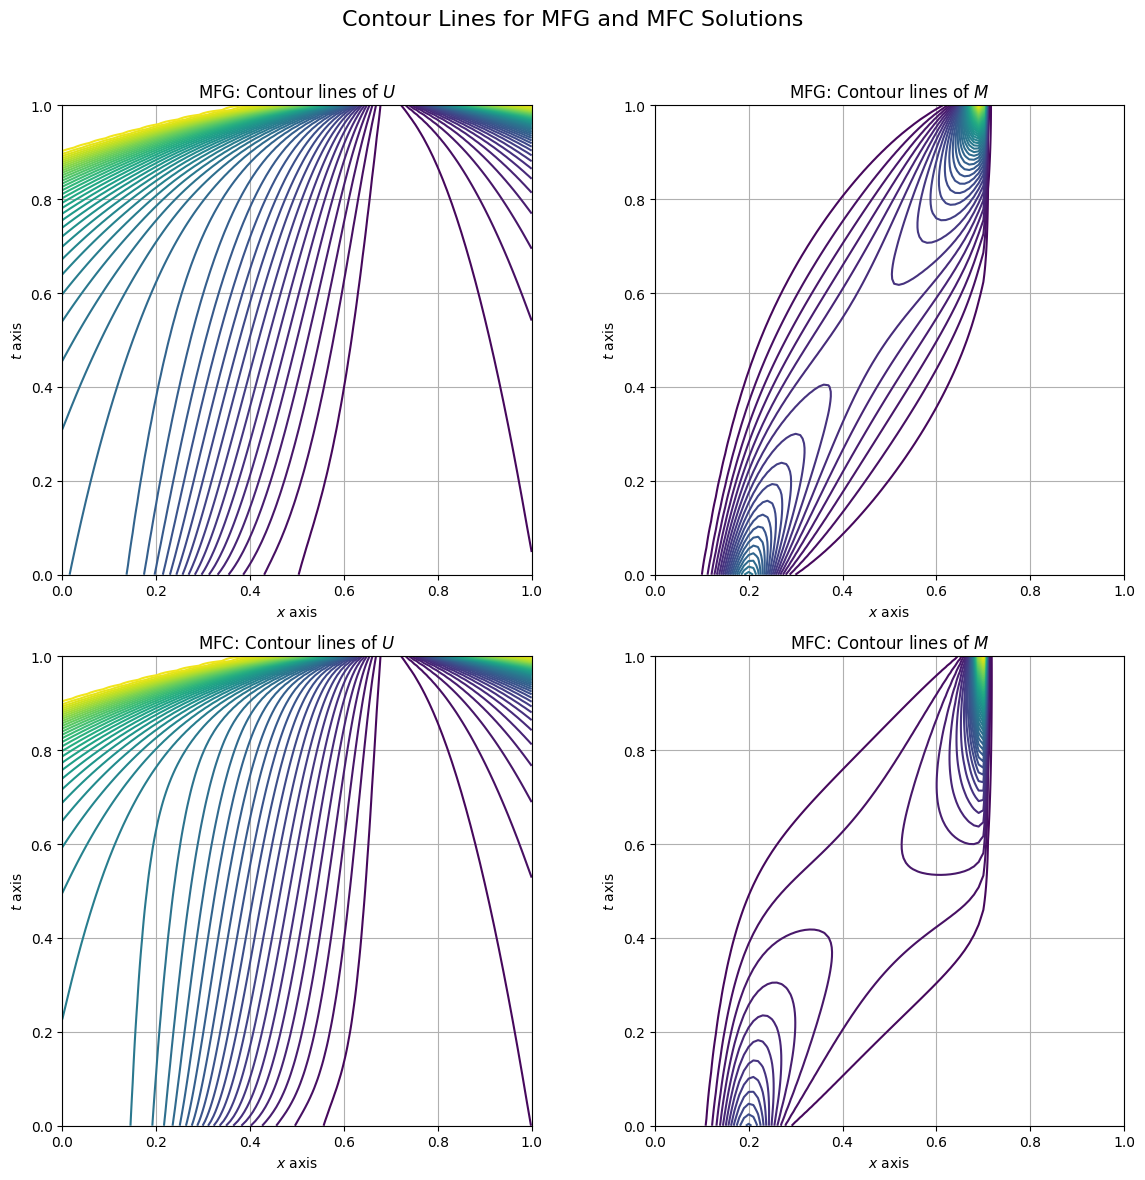

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Contour Lines for MFG and MFC Solutions', fontsize=16)

# Plot U contours for MFG
axes[0, 0].contour(space_grid, time_grid, U_fixed2, levels=50)
axes[0, 0].set_title('MFG: Contour lines of $U$')
axes[0, 0].set_xlabel('$x$ axis')
axes[0, 0].set_ylabel('$t$ axis')
axes[0, 0].grid(True)
axes[0, 0].set_aspect('equal')

# Plot M contours for MFG
axes[0, 1].contour(space_grid, time_grid, M_fixed2, levels=50)
axes[0, 1].set_title('MFG: Contour lines of $M$')
axes[0, 1].set_xlabel('$x$ axis')
axes[0, 1].set_ylabel('$t$ axis')
axes[0, 1].grid(True)
axes[0, 1].set_aspect('equal')

# Plot U contours for MFC
axes[1, 0].contour(space_grid, time_grid, U_fixed3, levels=50)
axes[1, 0].set_title('MFC: Contour lines of $U$')
axes[1, 0].set_xlabel('$x$ axis')
axes[1, 0].set_ylabel('$t$ axis')
axes[1, 0].grid(True)
axes[1, 0].set_aspect('equal')

# Plot M contours for MFC
axes[1, 1].contour(space_grid, time_grid, M_fixed3, levels=50)
axes[1, 1].set_title('MFC: Contour lines of $M$')
axes[1, 1].set_xlabel('$x$ axis')
axes[1, 1].set_ylabel('$t$ axis')
axes[1, 1].grid(True)
axes[1, 1].set_aspect('equal')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### **2. Compare with the solution of the MFG with the same parameters**

We can notice that the whole shape of the solution for MFG (Mean Field Game) and MFC (Mean Field Control) are approximately similar. However, there are more field lines with MFG that are regular compared to those of MFC.